Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0104 - mae: 0.0368 - val_loss: 8.9185e-05 - val_mae: 0.0061
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4899e-05 - mae: 0.0066 - val_loss: 9.2996e-05 - val_mae: 0.0067
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.4105e-05 - mae: 0.0063 - val_loss: 8.9572e-05 - val_mae: 0.0066
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0813e-05 - mae: 0.0062 - val_loss: 7.3059e-05 - val_mae: 0.0054
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0188e-05 - mae: 0.0061 - val_loss: 7.4448e-05 - val_mae: 0.0056
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9504e-05 - mae: 0.0061 - val_loss: 7.8729e-05 - val_mae: 0.0060
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8376e-05 - mae: 0.0061 - val_loss: 2.2304e-04 - val_mae: 0.0129
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0254e-05 - mae: 0.0062 - val_loss: 8.1135e-05 - val_mae: 0.0

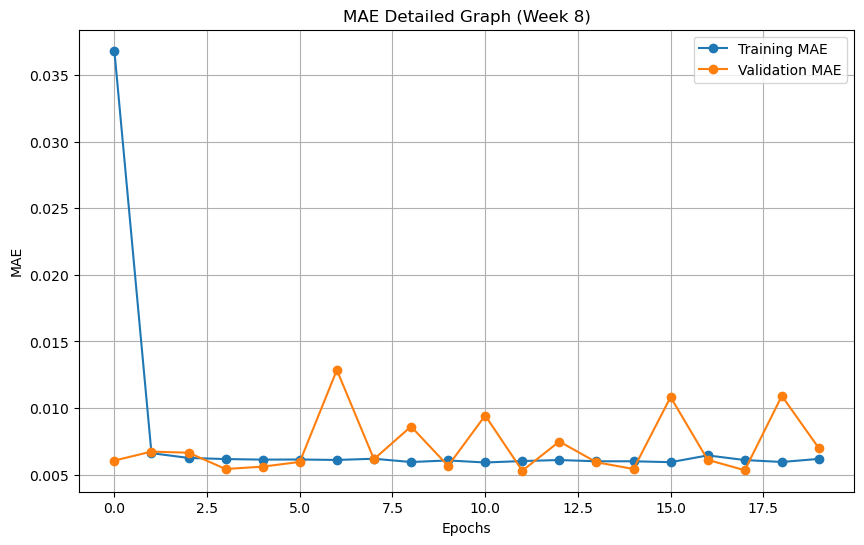

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

ask_path = r"C:\Users\sudha\Downloads\XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv"
bid_path = r"C:\Users\sudha\Downloads\XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv"

ask = pd.read_csv(ask_path)
bid = pd.read_csv(bid_path)

time_candidates = ["Time (UTC)", "Time", "Datetime", "Date"]
t_ask = next(c for c in time_candidates if c in ask.columns)
t_bid = next(c for c in time_candidates if c in bid.columns)

ask[t_ask] = pd.to_datetime(ask[t_ask])
bid[t_bid] = pd.to_datetime(bid[t_bid])

ask = ask.sort_values(t_ask).rename(columns={t_ask: "Time"})
bid = bid.sort_values(t_bid).rename(columns={t_bid: "Time"})

df = pd.merge_asof(ask, bid, on="Time", direction="nearest", tolerance=pd.Timedelta("5min"))
df = df.dropna().reset_index(drop=True)
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
close_col = "Close_Bid" if "Close_Bid" in df.columns else ("Close" if "Close" in df.columns else num_cols[0])

horizon = 5
df["y_future"] = df[close_col].shift(-horizon)
df = df.dropna().reset_index(drop=True)

features = df[num_cols].copy()
target = df["y_future"].values.astype("float32").reshape(-1, 1)

sx = MinMaxScaler()
sy = MinMaxScaler()

X_scaled = sx.fit_transform(features.values.astype("float32"))
y_scaled = sy.fit_transform(target).reshape(-1)

lookback = 5
M = len(df) - lookback + 1
F = X_scaled.shape[1]

X = np.zeros((M, lookback * F), dtype="float32")
Y = np.zeros((M,), dtype="float32")

for i in range(M):
    X[i] = X_scaled[i:i+lookback].reshape(-1)
    Y[i] = y_scaled[i+lookback-1]

train_size = int(0.8 * M)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer=Adam(), loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=128, verbose=1)

plt.figure(figsize=(10, 6))
plt.plot(history.history["mae"], marker="o", label="Training MAE")
plt.plot(history.history["val_mae"], marker="o", label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE Detailed Graph (Week 8)")
plt.legend()
plt.grid(True)
plt.show()
